In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from matplotlib import cm
from util.tools import build_adj_matrix,adj_to_edge_index
import sumolib
plt.rcParams['figure.figsize'] = (6, 4)
data_path = Path('ckpt/block_normal/Ours_GAT/400_gat_full_attn.fp16.npz')  

In [2]:
A = np.load(data_path)['arr_0']
E, T, H, N, _ = A.shape
print('Loaded', A.shape)
#shape (E, T, H, N, N)

Loaded (10, 24, 4, 16, 16)


In [3]:
### ---- SIMULATION FILES ----
net_file   = 'env/map/ff.net.xml'
route_file = 'env/map/ff_normal.rou.xml'     
seconds    = 3600       
tl_ids = ['B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3', 'D4', 'E1', 'E2', 'E3', 'E4']                     

In [4]:
adj        = build_adj_matrix(net_file, tl_ids)      # (N,N) Bool
edge_index = adj_to_edge_index(adj)                  # (2,E) Long

G = nx.DiGraph()
G.add_nodes_from(range(N))
for src, dst in edge_index.T.cpu().numpy():
    G.add_edge(src, dst)

# junction coordinates from SUMO
net     = sumolib.net.readNet(net_file)
pos = {idx: net.getNode(tl).getCoord()[:2]   # x,y
       for idx, tl in enumerate(tl_ids)}

print(G)

DiGraph with 16 nodes and 48 edges


## The road network 

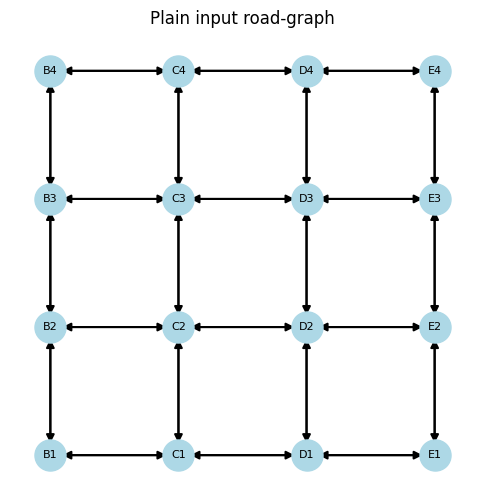

In [5]:
plt.figure(figsize=(6,6))

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, labels={i:tl for i,tl in enumerate(tl_ids)},
                        font_size=8)
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=12, width=1.5)
plt.title('Plain input road-graph')

plt.axis('equal'); plt.axis('off'); plt.show()

## 1 ▌Episode-mean heat-maps (all heads)

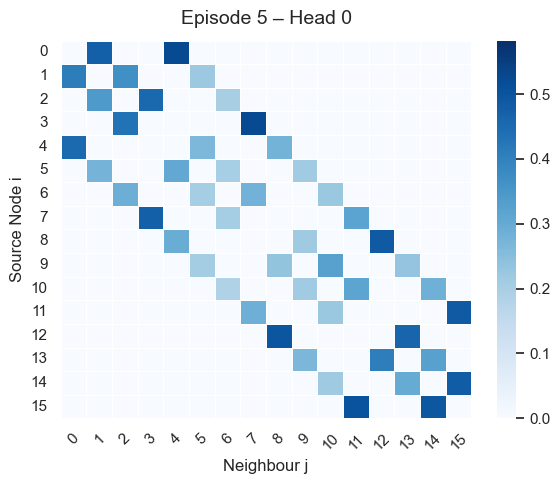

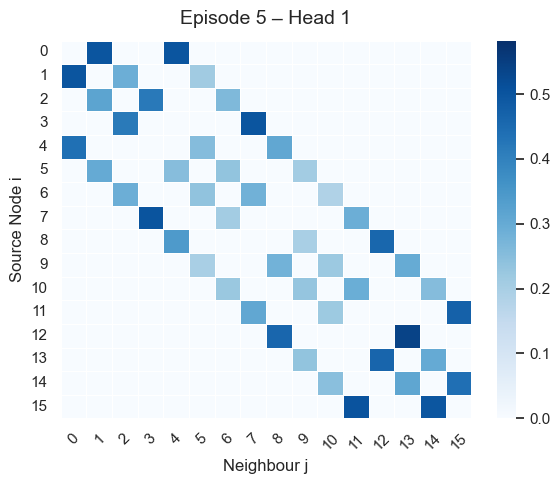

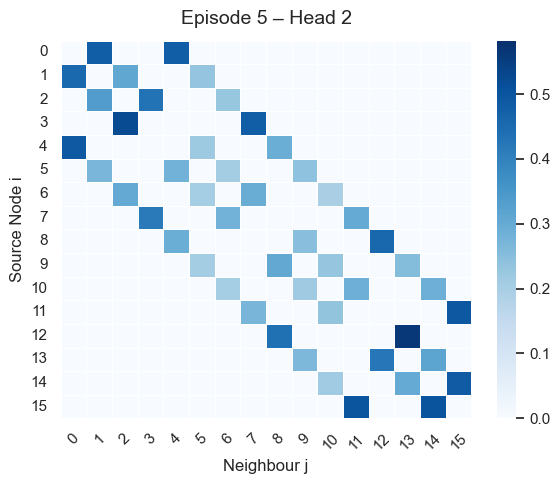

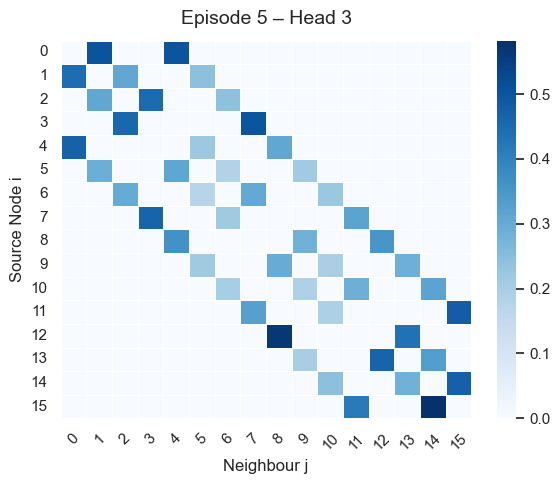

In [6]:
import seaborn as sns                      # easier annotations
sns.set(style="white")

ep = 5                                    # episode to inspect
M_ep = A[ep].mean(0)                       # (H, N, N)

for h in range(H):
    plt.figure(figsize=(6, 5))             # big enough per head
    ax = sns.heatmap(M_ep[h],
                     vmin=0, vmax=M_ep.max(),
                     cmap="Blues",
                     cbar=True,
                     linewidths=.5)

    ax.set_title(f'Episode {ep} – Head {h}', fontsize=14, pad=12)
    ax.set_xlabel('Neighbour j'); ax.set_ylabel('Source Node i')
    plt.xticks(rotation=45); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


## 2 ▌Temporal stripe for a single node

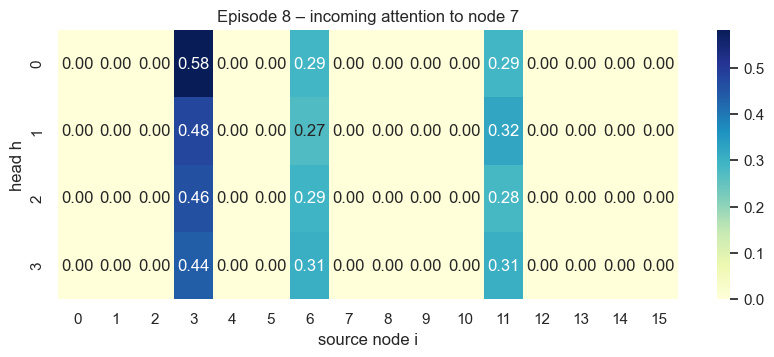

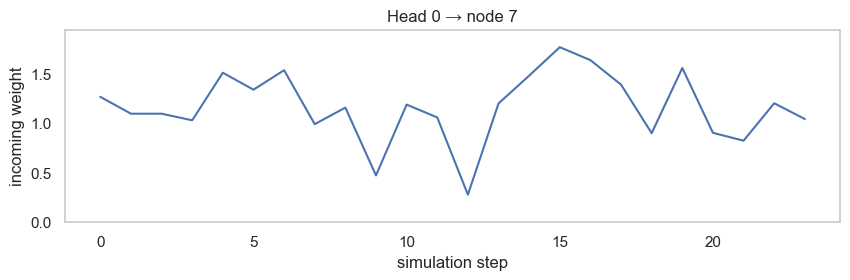

In [17]:
sns.set(style="whitegrid")

# ------------------------------------------------------------
# 1. CONFIG – choose node, episode, head
# ------------------------------------------------------------
node   = 7               # intersection index you care about
ep     = 8              # episode number to inspect (0-based)
head   = 0               # which head to plot as a line

# ------------------------------------------------------------
# 2. Extract data
# ------------------------------------------------------------
# A shape : (E, T, H, N, N)
inc   =A[ep].mean(0)[:, :, node]          # (H, N)  mean over time steps        
heads = [f'H{h}' for h in range(inc.shape[1])]

# ------------------------------------------------------------
# 3A. Heat-map  (episode × steps × heads)
# ------------------------------------------------------------
plt.figure(figsize=(10, 3.5))
sns.heatmap(inc, cmap="YlGnBu", annot=True, fmt=".2f")
plt.xlabel("source node i"); plt.ylabel("head h")
plt.title(f"Episode {ep} – incoming attention to node {node}")
plt.show()

# ------------------------------------------------------------
# 3B. Line plot  (single head)
# ------------------------------------------------------------
plt.figure(figsize=(10, 2.5))
inc_line = A[ep, :, head, :, node].sum(-1)    # sum over all sources
plt.plot(inc_line); plt.title(f"Head {head} → node {node}")
plt.xlabel("simulation step"); plt.ylabel("incoming weight")
plt.ylim(0, inc_line.max()*1.1); plt.grid(); plt.show()


## 3 ▌Attention-weighted graph overlay

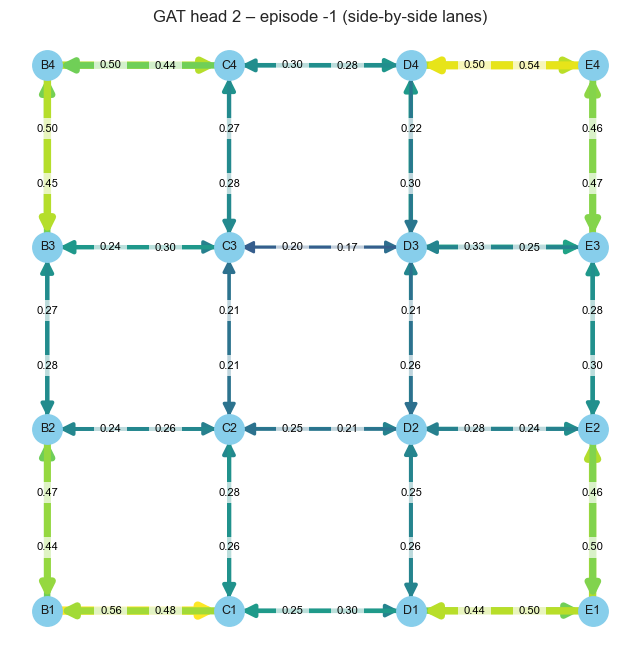

In [26]:

def draw_lane_graph(G, pos, edge_w, offset=0.13, cmap=cm.viridis):
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=450)
    nx.draw_networkx_labels(G, pos,
                            labels={i: tl for i, tl in enumerate(tl_ids)},
                            font_size=9)

    drawn = set()
    for (u, v), w_uv in edge_w.items():
        if (u, v) in drawn:
            continue
        w_vu = edge_w.get((v, u), None)
        # Geometry
        p1, p2 = np.array(pos[u]), np.array(pos[v])
        d = p2 - p1
        perp = np.array([-d[1], d[0]])
        perp = perp / (np.linalg.norm(perp) + 1e-9) * offset
        # Draw u→v to the right, v→u to the left
        if w_uv > 0:
            p1a, p2a = p1 + perp, p2 + perp
            nx.draw_networkx_edges(
                G, {u: p1a, v: p2a}, edgelist=[(u, v)],
                width=6 * w_uv / maxw,
                edge_color=[cmap(w_uv / maxw)],
                arrows=True, arrowsize=18, connectionstyle='arc3,rad=0.0')
            plt.text(*(0.65 * p1a + 0.35 * p2a), f'{w_uv:.2f}', fontsize=8,
                     ha='center', va='center', color='black', bbox=dict(fc='white', ec='none', alpha=0.7))
        if w_vu is not None and w_vu > 0:
            p1b, p2b = p1 - perp, p2 - perp
            nx.draw_networkx_edges(
                G, {v: p2b, u: p1b}, edgelist=[(v, u)],
                width=6 * w_vu / maxw,
                edge_color=[cmap(w_vu / maxw)],
                arrows=True, arrowsize=18, connectionstyle='arc3,rad=0.0')
            plt.text(*(0.65 * p2b + 0.35 * p1b), f'{w_vu:.2f}', fontsize=8,
                     ha='center', va='center', color='black', bbox=dict(fc='white', ec='none', alpha=0.7))
        drawn.add((u, v)); drawn.add((v, u))

    plt.axis('equal'); plt.axis('off')

# --- Setup, same as before
ep, head = -1, 2
W = A[ep].mean(0)[head]
edge_w = {(u, v): float(W[u, v])
          for u in range(N) for v in range(N)
          if W[u, v] > 0.01 and u != v}
maxw = max(edge_w.values()) if edge_w else 1.0
G_plot = nx.DiGraph(); G_plot.add_nodes_from(range(N))

draw_lane_graph(G_plot, pos, edge_w, offset=0.13)
plt.title(f'GAT head {head} – episode {ep} (side-by-side lanes)'); plt.show()



## 4 ▌Top-k edge bar chart

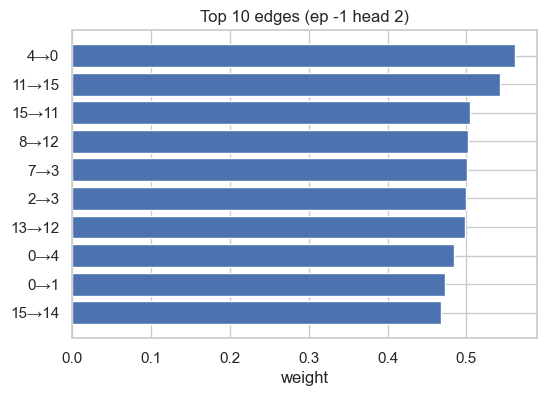

In [42]:
k, ep, head = 10, -1, 2
flat = A[ep].mean(0)[head].flatten()
idx  = np.argpartition(flat, -k)[-k:]
idx = idx[np.argsort(-flat[idx])]
src, dst = np.unravel_index(idx, (N,N))
plt.barh([f'{d}→{s}' for s,d in zip(src,dst)], flat[idx])
plt.gca().invert_yaxis(); plt.title(f'Top {k} edges (ep {ep} head {head})')
plt.xlabel('weight'); plt.show()


## 5 ▌Edge-time series

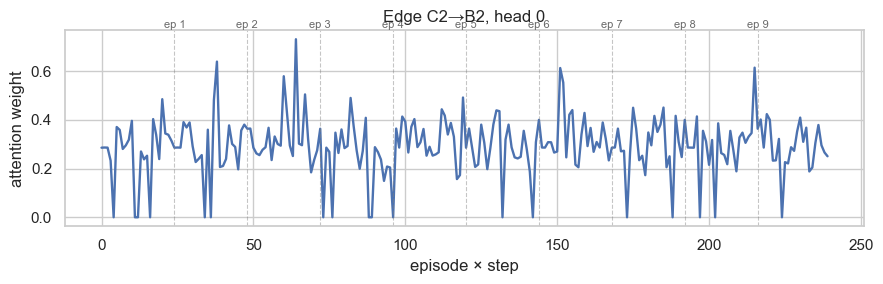

In [64]:
src, dst, head = 5, 1, 0
series = A[:, :, head, src, dst].reshape(E * T)
plt.figure(figsize=(9, 3))
plt.plot(series, lw=1.7)
plt.title(f'Edge {tl_ids[src]}→{tl_ids[dst]}, head {head}')
plt.xlabel('episode × step'); plt.ylabel('attention weight')

# Add vertical lines at each episode boundary
for ep in range(1, E):
    plt.axvline(ep * T, color='gray', lw=0.8, ls='--', alpha=0.45)
    plt.text(ep * T, plt.ylim()[1], f'ep {ep}', va='bottom', ha='center', fontsize=8, color='dimgray')

plt.tight_layout()
plt.show()


## 6 ▌Animated GIF of heat-maps

In [66]:
from matplotlib import animation


fig, ax = plt.subplots(figsize=(7, 7))  # Bigger figure
im = ax.imshow(A[0, 0, 0], vmin=0, vmax=A.max(), cmap='Blues')

# Optionally, set agent labels (if tl_ids is a list of N agent names)
N = A.shape[-1]
if 'tl_ids' in locals() and len(tl_ids) == N:
    ax.set_xticks(range(N))
    ax.set_yticks(range(N))
    ax.set_xticklabels(tl_ids, rotation=90)
    ax.set_yticklabels(tl_ids)

def update(f):
    ep, step = f // T, f % T
    im.set_data(A[ep, step, 0])
    ax.set_title(f'Head 0 – Episode {ep}, Step {step}')

ani = animation.FuncAnimation(fig, update, frames=E * T, interval=240)
ani.save('attention_evolution.gif', fps=10)
plt.close(fig)  # Avoids showing static final frame in some notebooks


MovieWriter ffmpeg unavailable; using Pillow instead.
